# **WOD OSD: global 1x1 bin**
- annual netCDF output
- WOD OSD data
- 1965 to 2021

## ***I. Setup: Directory & Data Initialization***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data source identification
Nlev=47
# read float data from working directory
dosd='ocldb1757352514.1605414_PFL'
Nosd=1
#Nosd=37

In [3]:
os.system('echo $USER > userid')
userid=np.genfromtxt('userid',dtype='<U36')
#
dirname=f'/glade/derecho/scratch/{userid}/WOD_annual_OSD2/'
varname='Nitrate'

In [4]:
os.system('rm -rf '+dirname)
os.system('mkdir -p '+dirname)

0

## ***II. Prepare Grid Cells***

In [5]:
# prep grid cells
# 1.0 x 1.0 degree resolution
res=1.0
xW=np.arange(-180,180,res) # Full lon scale (global coverage).
yS=np.arange(-90,90,res) # Full lat scale (global coverage.
xC=np.arange(-180,180,res)+res/2 # Full lon scale centered.
yC=np.arange(-90,90,res)+res/2 # Full lat scale centered.
xE=np.arange(-180,180,res)+res # Full lon scale degrees east.
yN=np.arange(-90,90,res)+res # Full lat scale degrees north.

# empty array
Nx=np.size(xC)
Ny=np.size(yC)

#
#z=[   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
#        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
#       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
#       4500., 5000., 5500.]

z=np.array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,
        275.,  300.,  325.,  350.,  375.,  400.,  425.,  450.,  475.,
        500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000.])

Nz=np.size(z)

## ***III. Setup Function for Binning***

In [6]:
def monthly_1deg_bin(Nlev,year,varname):
        
    # prepare array
    # first establish zeroes - (time, depth, lat, lon) - 12 represents months as integer
    # dd_osd: counts number of samples for above dimensions
    # sumX_osd: sums tracer values for later averaging
    # dd_prof: counts number of profiles at surface
    dd_osd=np.zeros((12,Nlev,180,360),dtype='int')
    sumX_osd=np.zeros((12,Nlev,180,360))
    dd_prof=np.zeros((12,180,360),dtype='int')
    
    # set 1.0 x 1.0 deg lon-lat grid
    Xw=np.arange(-180,180,1)
    Ys=np.arange(-90,90,1)
    
    # loop over each WOD ragged netCDF file
    for f in range(Nosd):
        if f==0:
            fn=dosd+'.nc'
        else:
            fn=dosd+str(f+1)+'.nc'
            
        # open bottle data & convert time to DateTimeIndex for slicing
        dsosd=xr.open_dataset(fn)
        # now loop over each cast in the netCDF file
        timeloc = pd.DatetimeIndex(dsosd['time'])
        Nprof0=np.size(timeloc)
        yearloc = timeloc.year
        uyear=np.unique(yearloc)
        
        if uyear[0]==1770:
            minyr=uyear[1]
        else:
            minyr=uyear[0]
        maxyr=uyear[-1]
        if (maxyr < year) | (minyr > year):
            note='skipping non-overlapping years...'
        else:

            # skip file if it doesn't overlap with target year
            print('processing '+fn)
            print('num of prof = '+str(Nprof0)+' max year = '+str(maxyr)+' min year = '+str(minyr))
            print('reading data...')
            # extract position variables - lat/lon
            lonloc=dsosd['lon'].to_numpy()
            latloc=dsosd['lat'].to_numpy()
            # get row size (z,T,S) are the same
            zrsize=dsosd['z_row_size'].to_numpy()
            orsize=dsosd[varname+'_row_size'].to_numpy()
            # get depth data
            zp0=dsosd['z'].to_numpy()
            # get tracer data
            no3p0=dsosd[varname].to_numpy()
            oflg0=dsosd[varname+'_WODflag'].to_numpy()
            # get month 
            monloc = timeloc.month
            
            zlevidx=0
            no3levidx=0
            lonloc[lonloc==-180.0]=-179.99 # avoid bin ambiguity

            # loop over each profile
            for nn in range(Nprof0):
                # current year and month
                mind=int(monloc[nn])-1
                yrnow=yearloc[nn]
                # determine x,y,month grid
                xind=np.where((Xw>=lonloc[nn]-1)&(Xw<lonloc[nn]))[0][0]
                yind=np.where((Ys>=latloc[nn]-1)&(Ys<latloc[nn]))[0][0]
                # determine the number of samples in this particular profile
                no3inc=orsize[nn]
                # obtain depth of the samples
                zp1=zp0[zlevidx:int(zlevidx+zrsize[nn])]
                # check if NO3 data exists
                if np.isnan(no3inc):
                    tmp_note='no data'
                else:
                    # get the profile and its quality flag
                    Nz1=int(no3inc)
                    no3p1=no3p0[no3levidx:int(no3levidx+no3inc)]
                    oflg1=oflg0[no3levidx:int(no3levidx+no3inc)]
                    no3levidx=int(no3levidx+no3inc) # update no3levidx here
                    # test
                    #if (xind==170)&(yind==145):
                    #    print(no3p1[:10])
                    #    print(oflg1[:10])
                    # vertical level limits to Nz
                    if (Nz1>Nlev):
                        Nz1=Nlev
                    for k in range(Nz1):
                        ## perform additional QC +/- 3*STD 
                        #olo=no3woa_an[mind,k,yind,xind]-3*obs_std
                        #ohi=no3woa_an[mind,k,yind,xind]+3*obs_std
                        #olo=no3woa_an[mind,k,yind,xind]-3*no3woa_sd[mind,k,yind,xind]
                        #ohi=no3woa_an[mind,k,yind,xind]+3*no3woa_sd[mind,k,yind,xind]
                        #if (no3p1[k]>=olo)&(no3p1[k]<=ohi)&(oflg1[k]==0):
                        if (oflg1[k]==0)&(yrnow==year):
                            sumX_osd[mind,k,yind,xind]=sumX_osd[mind,k,yind,xind]+no3p1[k]
                            dd_osd[mind,k,yind,xind]=dd_osd[mind,k,yind,xind]+1
                            if (k==0):
                                dd_prof[mind,yind,xind]=dd_prof[mind,yind,xind]+1
                    # --- done within profile loop
                # -------
                # now update the index for Z, T and S and go to the next profile
                zlevidx=int(zlevidx+zrsize[nn])
            # check if the number of sample matches up for the entire WOD file
            Nobs0=np.size(zp0)
            if zlevidx!=Nobs0:
                print('error! number of sample did not match')
            else:
                print('passed the sample count check')
    return sumX_osd,dd_osd,dd_prof

**Summary:**
- *Sets up storage arrays*
- *Loops over ragged bottle netCDF files*
- *Handles indexing for ragged arrays*
- *Filter by QC flags*
- *Accumulate into 1.0 degree bins (1.0 x 1.0 grid)*

## ***IV. Setup Function for Saving Bins***

In [7]:
def save_1deg_bin(dsum,dd,xc,yc,zc,year,var,dprof):
    fn=dirname+'/'+var+'_1x1bin_pfl_'+str(year)+'.nc'
    # compute mean tracer by bin
    dave=dsum/dd
    # define monthly timesteps
    mon=np.arange(f'{year}-01',f'{year+1}-01',dtype='datetime64[M]')
    # create main data array
    da=xr.DataArray(data=dave,name=var,dims=['time','depth','lat','lon'],\
                coords={'time':mon,'depth':zc,'lat':yc,'lon':xc})
    # convert to xarray
    ds=da.to_dataset()
    # add sample count, dimensions, and coordinates
    dd=xr.DataArray(data=dd,name='sample_count',dims=['time','depth','lat','lon'],\
                    coords={'time':mon,'depth':zc,'lat':yc,'lon':xc})
    ds['sample_count']=dd
    # add profile counts
    ddp=xr.DataArray(data=dprof,name='profile_count',dims=['time','lat','lon'],\
                    coords={'time':mon,'lat':yc,'lon':xc})
    ds['profile_count']=ddp
    # save as netcdf
    ds.to_netcdf(fn)
    return 1

**Summary:**
- *Compute mean tracer concentration by each bin*
- *`sample_count` is included for insights on data density*
- *`profile_count` is a count for each distinct profile*

## ***V. Perform Binning***

In [8]:
# define range of years to process (1965-2024)
YR=np.arange(1965,2025,1)
# make coordinate arrays (lon, lat, depth) local variables
xc=xC.copy()
yc=yC.copy()
zc=z.copy()
#
#loop over years
for yr in YR:
    print('=== working on '+str(yr)+' ===')
    # perform binning for year
    sumX,dd,dprof=monthly_1deg_bin(Nlev,yr,varname)
    # save bins
    dummy=save_1deg_bin(sumX,dd,xc,yc,zc,yr,varname,dprof)

=== working on 1965 ===
=== working on 1966 ===
=== working on 1967 ===
=== working on 1968 ===
=== working on 1969 ===
=== working on 1970 ===
=== working on 1971 ===
=== working on 1972 ===
=== working on 1973 ===
=== working on 1974 ===
=== working on 1975 ===
=== working on 1976 ===
=== working on 1977 ===
=== working on 1978 ===
=== working on 1979 ===
=== working on 1980 ===
=== working on 1981 ===
=== working on 1982 ===
=== working on 1983 ===
=== working on 1984 ===
=== working on 1985 ===
=== working on 1986 ===
=== working on 1987 ===
=== working on 1988 ===
=== working on 1989 ===
=== working on 1990 ===
=== working on 1991 ===
=== working on 1992 ===
=== working on 1993 ===
=== working on 1994 ===
=== working on 1995 ===
=== working on 1996 ===
=== working on 1997 ===
=== working on 1998 ===
=== working on 1999 ===
=== working on 2000 ===
=== working on 2001 ===
=== working on 2002 ===
=== working on 2003 ===
=== working on 2004 ===
=== working on 2005 ===
=== working on 2

## ***VI. Clip Yearly Data Together***

In [9]:
ds=xr.open_mfdataset(dirname+varname+'_1x1bin_pfl_*.nc')

*At edge of each year where files are output **(e.g. 12/31)**, create a new `xarray` dataset that clips the end of each annual dataset together chronologically so that we have a complete, comprehensive dataset of float data.*

## ***VII. Plot Profile Count***

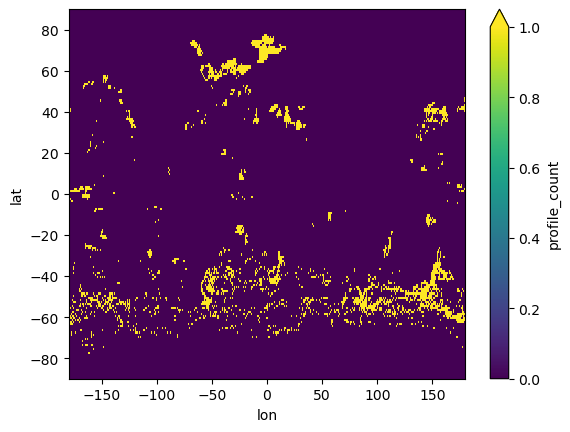

In [10]:
ds
ds['profile_count'].sum('time').plot(vmax=1)

In [11]:
ds.to_netcdf(varname+'_1x1bin_pfl_1965-2024.nc')

In [12]:
ds

<xarray.Dataset> Size: 35GB
Dimensions:        (time: 720, depth: 47, lat: 180, lon: 360)
Coordinates:
  * time           (time) datetime64[ns] 6kB 1965-01-01 ... 2024-12-01
  * depth          (depth) float64 376B 0.0 5.0 10.0 15.0 ... 900.0 950.0 1e+03
  * lat            (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    Nitrate        (time, depth, lat, lon) float64 18GB dask.array<chunksize=(12, 47, 180, 360), meta=np.ndarray>
    sample_count   (time, depth, lat, lon) int64 18GB dask.array<chunksize=(12, 47, 180, 360), meta=np.ndarray>
    profile_count  (time, lat, lon) int64 373MB dask.array<chunksize=(12, 180, 360), meta=np.ndarray>

In [13]:
ds.time

<xarray.DataArray 'time' (time: 720)> Size: 6kB
array(['1965-01-01T00:00:00.000000000', '1965-02-01T00:00:00.000000000',
       '1965-03-01T00:00:00.000000000', ..., '2024-10-01T00:00:00.000000000',
       '2024-11-01T00:00:00.000000000', '2024-12-01T00:00:00.000000000'],
      shape=(720,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 6kB 1965-01-01 1965-02-01 ... 2024-12-01